In [1]:
import numpy as np
import os
# os.environ['CUDA_VISIBLE_DEVICES']="" # uncomment this line if you only use cpu
import nltk
import keras.backend as K
from keras.models import Model
from keras.layers import Bidirectional, Input, Dense, Activation, Embedding, Dropout, TimeDistributed, GRU, Add, Lambda
from keras.layers import dot, concatenate
from keras.optimizers import Adam
from keras.callbacks import Callback
from keras.preprocessing.sequence import pad_sequences
from tensorflow.nn import ctc_beam_search_decoder
import tensorflow
from numpy.random import seed
seed(0)
import tensorflow as tf
tf.random.set_random_seed(0)

Using TensorFlow backend.


In this tutorial, we will use the Seq2Seq model to implement a tranlstion system which translates French text to English text.

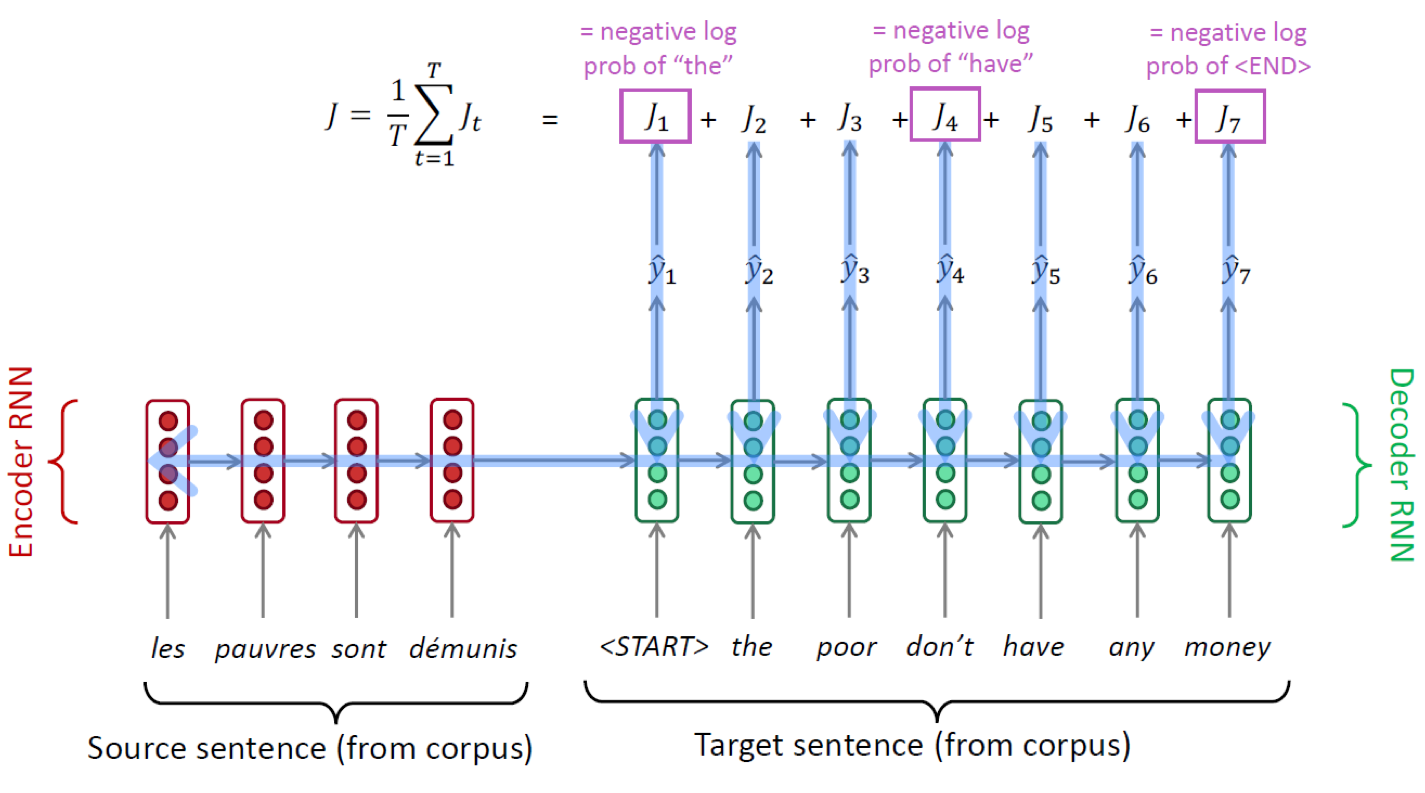

This figure illustrates the architecture of the sequence to sequence model.

It uses one encoder RNN and one decoder RNN. And the information passed from the encoder to the decoder is only the last hidden state of the encoder RNN. 

In this tutorial, we use GRU (https://towardsdatascience.com/understanding-gru-networks-2ef37df6c9be) to encode and decode sequence information.

In [2]:
from data_helper import load_translation_data

The load_translation_data function firstly load French-English sentence pairs of the Tatoeba project (http://www.manythings.org/anki/) from the disk.

Then it builds a vocabulary containing special tokens and words whose frequences are no less than 3 on the train set. 
The special tokens include `<pad>` for padding, `<sos>` for marking the beginning of sentence, `<eos>` for marking the end of sentence, `<unk>` for denoting the unknown words.

Next it maps sentences and labels to vectors based on the vocabulary.

Finally, it returns the processed train and validation data for the encoder and decoder respectively,
plus the built vocabulary.

You can check the details of this function in data_helper.py.


In [3]:
encoder_input_train, decoder_input_train, decoder_target_train, \
    encoder_input_valid, decoder_input_valid, decoder_target_valid, vocabulary = load_translation_data()
vocab_size = len(vocabulary)

print('encoder_input_train.shape', encoder_input_train.shape)
print('decoder_input_train.shape', decoder_input_train.shape)
print('decoder_target_train.shape', decoder_target_train.shape)
print('encoder_input_valid.shape',encoder_input_valid.shape)
print('decoder_input_valid.shape',decoder_input_valid.shape)
print('decoder_target_valid.shape', decoder_target_valid.shape)
print('Vocab Size', vocab_size)

num_training_data = encoder_input_train.shape[0]
encoder_sequence_length = encoder_input_train.shape[1]
decoder_sequence_length = decoder_input_train.shape[1]

encoder_input_train.shape (12244, 10)
decoder_input_train.shape (12244, 10)
decoder_target_train.shape (12244, 10)
encoder_input_valid.shape (1225, 10)
decoder_input_valid.shape (1225, 10)
decoder_target_valid.shape (1225, 10)
Vocab Size 3243


## Seq2Seq model for Neural Machine Translation

In [4]:
# training parameters
dropout_rate = 0.2
epochs = 20
batch_size = 64
embedding_dim = 100

# gru parameters
hidden_dim = 100
num_encoder_layer = 2
num_decoder_layer = 1

def get_model():

    # encoder_input -> [batch_size, encoder_sequence_length]
    # decoder_input -> [batch_size, decoder_sequence_length]
    encoder_input = Input(shape=(encoder_sequence_length,), dtype='int32')
    decoder_input = Input(shape=(decoder_sequence_length,), dtype='int32')

    # the word embedding layer shared by the encoder and decoder.
    # mask_zero is set to be true because word index 0 means padding
    # and should be masked out (see https://keras.io/api/layers/core_layers/embedding/ for details)
    emb_layer = Embedding(input_dim=vocab_size,
                          output_dim=embedding_dim, mask_zero=True)
        # embedding -> [batch_size, sequence_length, embedding_dim]
    encoder_input_embed = emb_layer(encoder_input)

    # dropout at embedding layer
    encoder_input_droped = Dropout(dropout_rate)(encoder_input_embed)

    encoder_inputs = [encoder_input_droped]


    # denote the number of encoder layer as N

    # we first add N − 1 layer(s) of Bidirectional GRU, which return(s) sequences only
    for i in range(0, num_encoder_layer-1):
        # shape: [batch_size, sequence_length, 2*hidden_dim]
        encoder_output = Bidirectional(GRU(units=hidden_dim, 
                                           return_sequences=True))(encoder_inputs[i])
        # add Dropout layers between GRU layers.
        encoder_output_droped = Dropout(dropout_rate)(encoder_output)

        # use the output of this layer as the input of next layer
        encoder_inputs.append(encoder_output_droped)


    # the last layer is a Bidirectional GRU, which returns sequence and the last state of each direction

    # shape: [batch_size, sequence_length, 2*hidden_dim], [batch_size, hidden_dim], [batch_size, hidden_dim]
    encoder_output, encoder_last_h, encoder_last_hr = Bidirectional(GRU(units=hidden_dim, 
                                                                        return_sequences=True, 
                                                                        return_state=True))(encoder_inputs[-1])
    # shape: [batch_size, sequence_length, embedding_dim]
    decoder_input_embed = emb_layer(decoder_input)

    # dropout at embedding layer
    decoder_input_droped = Dropout(dropout_rate)(decoder_input_embed)

    # denote the number of decoder layer as M


    # in the first layer, we add an Unidirectional GRU layer where
    # the initial_state is set to be the column-wise concatenation of the encoder_hidden_states
    # shape: [batch_size, sequence_length, 2*hidden_dim]
    decoder_output = GRU(units=2*hidden_dim, 
                         return_sequences=True)(decoder_input_droped, 
                                      initial_state=concatenate([encoder_last_h, encoder_last_hr], axis=1))
    decoder_outputs = [decoder_output]


    # build the remaining M-1 layers
    for i in range(1, num_decoder_layer):
        # add Dropout layers between GRU layers.
        decoder_output_droped = Dropout(dropout_rate)(decoder_outputs[-1])

        # shape: [batch_size, sequence_length, 2*hidden_dim]
        decoder_output = GRU(units=2*hidden_dim, 
                             return_sequences=True)(decoder_output_droped)

        # use the output of this layer as the input of next layer
        decoder_outputs.append(decoder_output)


    # for the output layer, we use one Dense layer with softmax activation wrapped by 
    # TimeDistributed layer 

    # shape: [batch_size, sequence_length, vocab_size]
    output = TimeDistributed(
            Dense(units=vocab_size, activation='softmax'))(decoder_outputs[-1])
    return Model(inputs=[encoder_input, decoder_input], outputs=[output])

### Helper functions

In [5]:
def recover_sentence(x, idx2word):
    '''
    Convert the word indices to word strings
    
    :param x: sentence to be recovered
    :param idx2word: a dictionary mapping word indices to word strings
    '''
    s = []
    for idx in x:
        word = idx2word[idx]
        if word == '<sos>':
            continue
        elif word == '<eos>':
            break
        elif word == '<pad>':
            break
        s.append(word)
    return s

In [6]:
class TestCallback(Callback):
    """
    Calculate BLEU
    """

    def __init__(self, test_data, model, vocabulary, decode_strategy, beam_width=None):
        self.test_data = test_data
        self.model = model
        self.vocabulary = vocabulary
        self.idx2word = dict()
        for k, v in self.vocabulary.items():
            self.idx2word[v] = k
        
        self.decode_strategy = decode_strategy
        self.beam_width = beam_width
        
    
    
    def evaluate_bleu(self, target, output):
        N = target.shape[0]
        sum_bleu = 0.0
        for i in range(N):
            t = recover_sentence(target[i], self.idx2word)
            o = recover_sentence(output[i], self.idx2word)
            bleu = nltk.translate.bleu_score.sentence_bleu([t], o)
            sum_bleu += bleu
        return sum_bleu / N
    
    def on_epoch_end(self, epoch, logs={}):
        [encoder_input, decoder_input, decoder_target] = self.test_data
        
        if(self.decode_strategy == 'greedy'):
            
            decoder_output = seq2seq_predict_greedy(
                self.model, encoder_input, decoder_input_train.shape[1], 
                self.vocabulary['<sos>'], self.vocabulary['<eos>'],)
        elif(self.decode_strategy == 'beam_search'):
            decoder_output = seq2seq_predict_beam_search(
                self.model, encoder_input, decoder_input_train.shape[1], 
                self.vocabulary['<sos>'],self.vocabulary['<eos>'], self.vocabulary['<pad>'], 
                self.beam_width
            )
        
        bleu= self.evaluate_bleu(decoder_target, decoder_output)
        print('Validation Set BLEU: %f' % (bleu))
        

    

### Train the model

In [7]:
model = get_model()

adam = Adam()
model.compile(loss='sparse_categorical_crossentropy', optimizer=adam)

print(model.summary())

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 10)           0                                            
__________________________________________________________________________________________________
input_1 (InputLayer)            (None, 10)           0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 10, 100)      324300      input_1[0][0]                    
                                                                 input_2[0][0]                    
________________

In [8]:
from tqdm import tqdm
def seq2seq_predict_beam_search(seq2seq_model, encoder_input, decoder_sequence_length, sos_idx, eos_idx, pad_idx, 
                                K_beams):
    
    '''
    Use the input seq2seq model to generate sequences given input sequences using beam search.
    
    :param seq2seq_model: the seq2seq model to make prediction
    :param encoder_input: input sequence to the encoder
    :param decoder_sequence_length: maximum sentence length
    :param sos_idx: the index of <sos> token in the vocabulary
    :param eos_idx: the index of <eos> token in the vocabulary
    :param pad_idx: the index of <pad> token in the vocabulary
    :param K_beams: the beam width parameter in beam search
    '''
        
    decoder_input = np.zeros(
        shape=(len(encoder_input), decoder_sequence_length))
    # set the first token in each decoder input sequence to be '<sos>'
    decoder_input[:, 0] = sos_idx
    
    output_encodings = []
    batch_size = len(encoder_input)

    for i in tqdm(range(batch_size)):

        start = [sos_idx]

        start_word = [[start, 0.0]] # (list(token_id), probability)

        while len(start_word[0][0]) < decoder_sequence_length:
            temp_beams = []
            for s in start_word:
                current_decoding  = pad_sequences([s[0]], maxlen=decoder_sequence_length, padding='post')
                            # sequence of most probable words 
                            # based on the previous steps
    #             print("current_decoding", current_decoding)
                preds = seq2seq_model.predict([np.expand_dims(encoder_input[i, :], 0), current_decoding])
    #             print("preds", preds.shape)
                preds = preds[0, len(start_word[0][0])-1, :]
    #             print(preds[:10])
                word_preds = np.argsort(preds)[-K_beams:] 
                # sort predictions based on the probability, take k largest

                # Getting the top <K_beams>(n) predictions and creating a 
                # new list so as to put them via the model again
                for w in word_preds:

                    next_decoding, prob = s[0][:], s[1]
                    next_decoding.append(w)
                    prob += np.log(preds[w]) # assign a probability to each K words4
                    temp_beams.append([next_decoding, prob])
            start_word = temp_beams
            # Sorting according to the probabilities
            start_word = sorted(start_word, reverse=False, key=lambda l: l[1])

            # Getting the top beams
            start_word = start_word[-K_beams:]

        start_word = start_word[-1][0] # select the best beam
        final_decodings = [i for i in start_word]

        final_decoding = []

        for i in final_decodings:
            if i != eos_idx:
                final_decoding.append(i)
            else:
                break
        output_encodings.append(final_decoding)
    return output_encodings

In [9]:
def seq2seq_predict_greedy(seq2seq_model, encoder_input, decoder_sequence_length, sos_idx, eos_idx):
    
    '''
    Use the input seq2seq model to generate sequences given input sequences using greedy search.
    
    :param seq2seq_model: the seq2seq model to make prediction
    :param encoder_input: input sequence to the encoder
    :param decoder_sequence_length: maximum sentence length
    :param sos_idx: the index of <sos> token in the vocabulary
    '''
    
    # create a placeholder for decoder input in the prediction stage
    decoder_input = np.zeros(
        shape=(len(encoder_input), decoder_sequence_length))
    
    # set the first token in each decoder input sequence to be '<sos>'
    decoder_input[:, 0] = sos_idx
    
    
    for i in range(1, decoder_sequence_length):# iterate over each time step
        
        # In the prediction stage, at each time step, the output of the seq2seq decoder is based on 
        # encoder_input (i.e., the source sequence), and decoder_input (i.e.,'<sos>' token 
        # if it is the first time step, or the output tokens from the decoder in 
        # all previous time steps if it is not the first time step)
        
        # shape: [len(encoder_input), sequence_length, vocab_size]
        
        softmax_output = seq2seq_model.predict(
            [encoder_input, decoder_input], batch_size=batch_size)
        
        # get the index of the word with the maximum probability
        # shape: [len(encoder_input), sequence_length]
        output = softmax_output.argmax(axis=2)
        
                 
        # include the output at the current time step as the decoder input in next
        # time step
        decoder_input[:, i] = output[:, i-1]
    
    # remove eos
    output_encodings = []
    for i in range(len(encoder_input)):
        final_decoding = []
        for w in output[i, :]:
            if w != eos_idx:
                final_decoding.append(w)
            else:
                break
        output_encodings.append(final_decoding)
    
    return output_encodings

In [10]:
history = model.fit([encoder_input_train, decoder_input_train], np.expand_dims(decoder_target_train, axis=2),
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    callbacks=[TestCallback((encoder_input_valid, decoder_input_valid, decoder_target_valid), model,
                                            vocabulary, 'beam_search', 3)])


Epoch 1/20
12244/12244 [==============================] - 21s 2ms/step - loss: 2.9482


100%|██████████| 1225/1225 [05:49<00:00,  3.50it/s]
/home/zlinai/.local/lib/python3.7/site-packages/nltk/translate/bleu_score.py:523: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/home/zlinai/.local/lib/python3.7/site-packages/nltk/translate/bleu_score.py:523: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/home/zlinai/.local/lib/python3.7/site-packages/nltk/translate/bleu_score.py:523: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Co

Validation Set BLEU: 0.007476
Epoch 2/20
12244/12244 [==============================] - 16s 1ms/step - loss: 2.0917


100%|██████████| 1225/1225 [05:34<00:00,  3.66it/s]


Validation Set BLEU: 0.010776
Epoch 3/20
12244/12244 [==============================] - 18s 1ms/step - loss: 1.8504


100%|██████████| 1225/1225 [05:34<00:00,  3.67it/s]


Validation Set BLEU: 0.013515
Epoch 4/20
12244/12244 [==============================] - 18s 1ms/step - loss: 1.6363


100%|██████████| 1225/1225 [05:34<00:00,  3.66it/s]


Validation Set BLEU: 0.024871
Epoch 5/20
12244/12244 [==============================] - 18s 1ms/step - loss: 1.4941


100%|██████████| 1225/1225 [05:34<00:00,  3.66it/s]


Validation Set BLEU: 0.033084
Epoch 6/20
12244/12244 [==============================] - 18s 1ms/step - loss: 1.3885


100%|██████████| 1225/1225 [05:34<00:00,  3.66it/s]


Validation Set BLEU: 0.034143
Epoch 7/20
12244/12244 [==============================] - 18s 1ms/step - loss: 1.3051


100%|██████████| 1225/1225 [05:34<00:00,  3.66it/s]


Validation Set BLEU: 0.033540
Epoch 8/20
12244/12244 [==============================] - 18s 1ms/step - loss: 1.2379


100%|██████████| 1225/1225 [05:34<00:00,  3.67it/s]


Validation Set BLEU: 0.036177
Epoch 9/20
12244/12244 [==============================] - 18s 1ms/step - loss: 1.1773


100%|██████████| 1225/1225 [05:34<00:00,  3.67it/s]


Validation Set BLEU: 0.039957
Epoch 10/20
12244/12244 [==============================] - 18s 1ms/step - loss: 1.1177


100%|██████████| 1225/1225 [05:34<00:00,  3.66it/s]


Validation Set BLEU: 0.050395
Epoch 11/20
12244/12244 [==============================] - 17s 1ms/step - loss: 1.0659


100%|██████████| 1225/1225 [05:34<00:00,  3.66it/s]


Validation Set BLEU: 0.052573
Epoch 12/20
12244/12244 [==============================] - 18s 1ms/step - loss: 1.0101


100%|██████████| 1225/1225 [05:34<00:00,  3.66it/s]


Validation Set BLEU: 0.070926
Epoch 13/20
12244/12244 [==============================] - 18s 1ms/step - loss: 0.9600


100%|██████████| 1225/1225 [05:34<00:00,  3.66it/s]


Validation Set BLEU: 0.084731
Epoch 14/20
12244/12244 [==============================] - 18s 1ms/step - loss: 0.9154


100%|██████████| 1225/1225 [05:35<00:00,  3.66it/s]


Validation Set BLEU: 0.078790
Epoch 15/20
12244/12244 [==============================] - 18s 1ms/step - loss: 0.8732


100%|██████████| 1225/1225 [05:35<00:00,  3.66it/s]


Validation Set BLEU: 0.099352
Epoch 16/20
12244/12244 [==============================] - 18s 1ms/step - loss: 0.8318


100%|██████████| 1225/1225 [05:34<00:00,  3.67it/s]


Validation Set BLEU: 0.124146
Epoch 17/20
12244/12244 [==============================] - 17s 1ms/step - loss: 0.7940


100%|██████████| 1225/1225 [05:34<00:00,  3.67it/s]


Validation Set BLEU: 0.131435
Epoch 18/20
12244/12244 [==============================] - 18s 1ms/step - loss: 0.7573


100%|██████████| 1225/1225 [05:33<00:00,  3.67it/s]


Validation Set BLEU: 0.149025
Epoch 19/20
12244/12244 [==============================] - 18s 1ms/step - loss: 0.7247


100%|██████████| 1225/1225 [05:33<00:00,  3.67it/s]


Validation Set BLEU: 0.165279
Epoch 20/20
12244/12244 [==============================] - 18s 1ms/step - loss: 0.6933


100%|██████████| 1225/1225 [05:32<00:00,  3.68it/s]


Validation Set BLEU: 0.173621
